In [7]:
import numpy as np

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
import librosa
import librosa.display
#import IPython.display as ipd

import tqdm
from tqdm import tqdm

import random
import pickle

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [8]:
allNormal = np.load("allNormal3.npy", allow_pickle=True)
allAnomaly = np.load("allAnomaly3.npy", allow_pickle=True)

In [179]:
def makeWindows(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec]
            window = melspectrogram[:,start:end]
            windows.append(window)
            start += intervalLength
            end += intervalLength
    return windows
        
def makeWindows2(data, numWindows): #makes the windows with the metadata to amke it reconstructable
    windows = []
    classifiers = {}
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        classifiers[mspec] = data[mspec][1]
        for interval in range(numWindows):
            melspectrogram = data[mspec][0]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows, classifiers

def makeWindows3(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec][0]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows

def makeWindows4(data, numWindows): #makes the windows with the metadata to amke it reconstructable, takes in a singular window
    windows = []
    intervalLength = int(430 / numWindows)
    start = 0
    end = intervalLength
    classifier = data[1]
    melspectrogram = data[0]
    for interval in range(numWindows):
        window = melspectrogram[:,start:end]
        windows.append([window, interval])
        start += intervalLength
        end += intervalLength
        
    npWindows = np.array([]).reshape(0,1,11,86)
    for j in range(len(windows)):
        npWindows = np.vstack([npWindows, windows[j][0].reshape(-1,1,11,86)])
    return npWindows, classifier

def sortWindows(arr):#sorts from least to greatest in terms of the "mel-order"
    for mspec in range(len(arr)):
        for mspec2 in range(mspec, len(arr)):
            if arr[mspec][2] > arr[mspec2][2]:
                temp = arr[mspec]
                arr[mspec] = arr[mspec2]
                arr[mspec2] = temp
    return arr

def reconstruct(arr, numWindows, size): #reconstructs the Mel spectrograms after being window sliced and shuffled
    arr = arr.tolist()
    melspectrograms = []
    allRecon = []
    for melID in tqdm(range(size)):
        mspec = []
        for a in range(len(arr)):
            print(a)
            if arr[a][1] == melID:
                mspec.append(arr[a])
        sortWindows(mspec)
        mspec = np.array(mspec)
        whole = mspec[0][0]
        for time in range(1,numWindows):
            whole = np.concatenate((whole, mspec[time][0]), axis=1)
        whole = whole.tolist()
        allRecon.append(whole)
    return allRecon

def reconstruct2(numpyArray, numWindows): #reconstructs the Mel spectrograms after being window sliced and shuffled
    numpyArray = numpyArray.tolist()
    #numpyArray = sortWindows2(numpyArray)
    mspec = np.array(numpyArray)
    whole = mspec[0]
    for time in range(1,numWindows):
        whole = np.concatenate((whole, mspec[time]), axis=1)
    return whole

def sortWindows2(arr):#sorts from least to greatest in terms of the "mel-order", takes in a python list
    for mspec in range(len(arr)):
        for mspec2 in range(mspec, len(arr)):
            if arr[mspec][1] > arr[mspec2][1]:
                temp = arr[mspec]
                arr[mspec] = arr[mspec2]
                arr[mspec2] = temp
    return arr

In [10]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #starting size: (11,86)
            nn.Conv2d(1,32,3), #input: 11, 86 -> 9, 84
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), #input: 4, 42 -> 2,40
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) #input: 2, 40 -> 1, 20
            #final: 1, 20
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), #input: 1,20 -> 3,41
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 6, stride=2, output_padding = (1,0)) #input: 3, 41 -> 10,86
            
            #final: 10,86
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x=self.decoder(x)
        return x

In [11]:
print(len(allNormal),len(allAnomaly))

5399 5399


In [12]:
test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

10798


In [178]:
len(windows)

4

In [7]:
# windows, classifiers = makeWindows2(test, 5)

100%|██████████| 10798/10798 [00:00<00:00, 78746.07it/s]


In [204]:
model = pickle.load(open('model_14.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], 5)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,86))
    mspec = reconstruct2(output.detach().numpy(), 5)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()



100%|██████████| 10798/10798 [00:28<00:00, 376.00it/s]


In [202]:
print(min(val_loss))

tensor(177.9237)


In [206]:
val_loss = np.array(val_loss)
val_loss = val_loss * -1
print(val_loss)

[177.98997 199.37886 207.93152 ... 203.64319 186.79057 169.2211 ]


In [207]:
print(min(val_loss))

83.77007


In [32]:
    correct = 0
total = len(test)
predictions = []
#threshold = 10

TPRs = []
FPRS = []
with torch.no_grad():
    for threshold in range(0, 110, 10):
#         TP = 0 #true positive
#         TN = 0 #true negative
#         FP = 0 # false positive
#         FN = 0 # false negative
        for j in tqdm(range(len(test))):
            if lossDictionary[j] > threshold:
#                 if [0,1] == classifiers[j].tolist():
                predictions.append([0,1])
#                     TN += 1
#                 else:
#                     predictions[j] = [0,1]
#                     FN += 1
            elif lossDictionary[j] <= threshold:
#                 if [1,0] == classifiers[j].tolist:
                predictions.append([1,0])
#                     TP += 1
#                 else:
#                     predictions[j] = [1,0]
#                     FP += 1
#         TPR = TP / (TP+FN)
#         FPR = FP / (FP+TN)
#         TPRs.append(TPR)
#         FPRs.append(FPR)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#https://www.projectpro.io/recipes/plot-roc-curve-in-python

print(val_acc)

100%|██████████| 10798/10798 [00:00<00:00, 599035.71it/s]

0.0


In [4]:
for i in range(0, 110, 10):
    print(i)

0
10
20
30
40
50
60
70
80
90
100


In [31]:
lossDictionary[j]

[16.579851150512695,
 17.127460479736328,
 18.278640747070312,
 19.07735824584961,
 17.291074752807617]

In [11]:
# val = min(val_loss)
# index = -1
# for i in range(len(val_loss)):
#     if val == val_loss[i]:
#         break
#     index = i
# print(i)

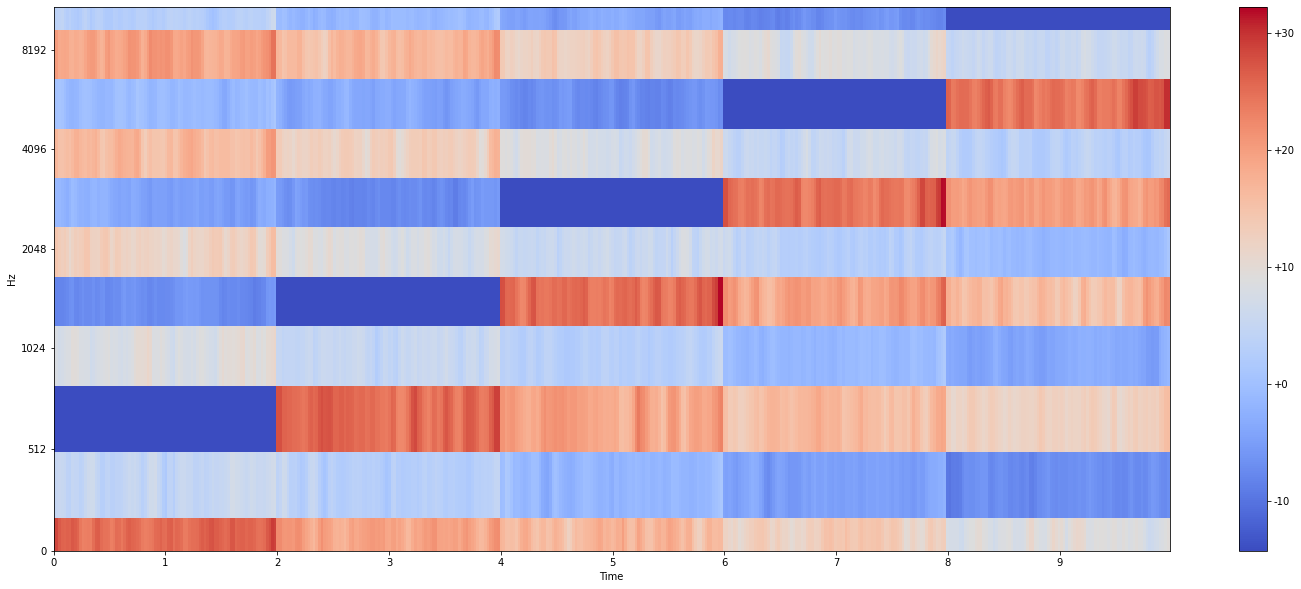

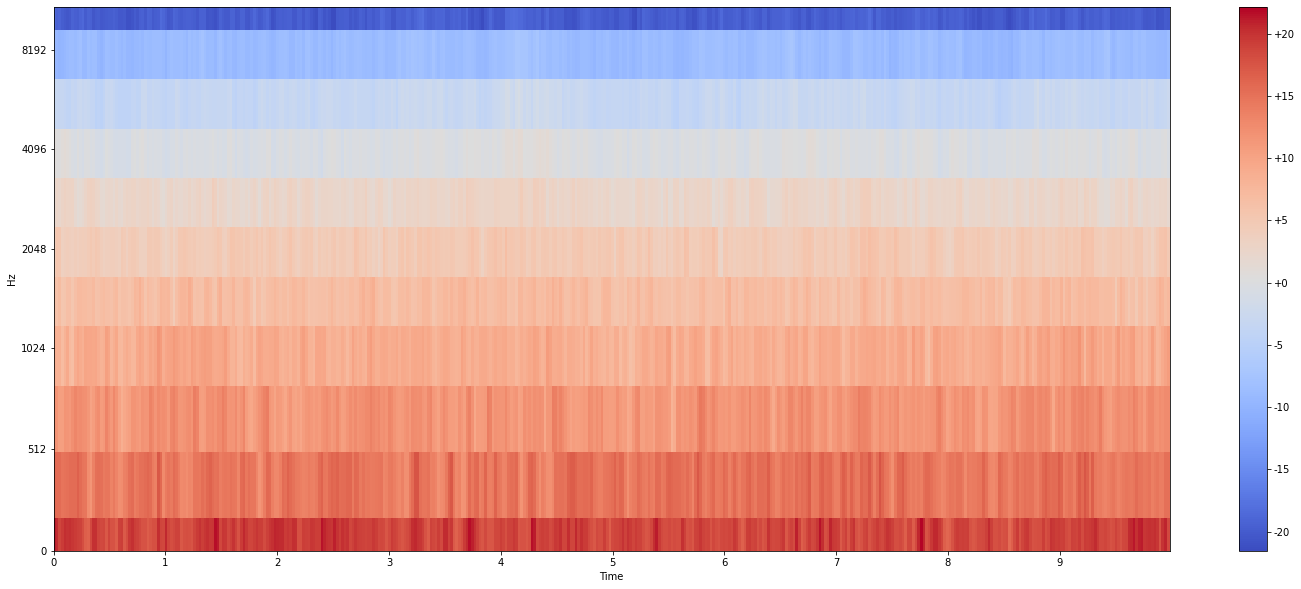

TypeError: expected np.ndarray (got list)

In [216]:
a=200
model = pickle.load(open('model_14.pt', 'rb'))
windows, classifier = makeWindows4(test[a], 5)
windows = torch.from_numpy(windows).type(torch.float32)
o = model(windows.view(-1,1,11,86))
mspec = reconstruct2(output.detach().numpy(), 5)

plt.figure(figsize=(25,10))
librosa.display.specshow(mspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

plt.figure(figsize=(25,10))
librosa.display.specshow(test[a][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

thing = criterion(torch.from_numpy(mspec).type(torch.float32).view(1,11,430), torch.from_numpy(test[a]).type(torch.float32).view(-1,1,11,430))
print(thing.item())

In [13]:
test[1][1]

array([1, 0])

In [14]:
val_loss

[tensor(16.5799, grad_fn=<MseLossBackward0>),
 tensor(17.1275, grad_fn=<MseLossBackward0>),
 tensor(18.2786, grad_fn=<MseLossBackward0>),
 tensor(19.0774, grad_fn=<MseLossBackward0>),
 tensor(17.2911, grad_fn=<MseLossBackward0>),
 tensor(19.6842, grad_fn=<MseLossBackward0>),
 tensor(19.2081, grad_fn=<MseLossBackward0>),
 tensor(19.8957, grad_fn=<MseLossBackward0>),
 tensor(18.9276, grad_fn=<MseLossBackward0>),
 tensor(21.0269, grad_fn=<MseLossBackward0>),
 tensor(35.6515, grad_fn=<MseLossBackward0>),
 tensor(22.2703, grad_fn=<MseLossBackward0>),
 tensor(27.2200, grad_fn=<MseLossBackward0>),
 tensor(23.6562, grad_fn=<MseLossBackward0>),
 tensor(33.9465, grad_fn=<MseLossBackward0>),
 tensor(12.4738, grad_fn=<MseLossBackward0>),
 tensor(14.0280, grad_fn=<MseLossBackward0>),
 tensor(14.3260, grad_fn=<MseLossBackward0>),
 tensor(14.3901, grad_fn=<MseLossBackward0>),
 tensor(14.8387, grad_fn=<MseLossBackward0>),
 tensor(30.0187, grad_fn=<MseLossBackward0>),
 tensor(10.2187, grad_fn=<MseLossB

In [15]:
a = 2
w, c = makeWindows2(test[0:2], 5)
output = model(torch.from_numpy(w[a][0]).type(torch.float32).view(-1,1,11,86))
loss = criterion(output.view(-1,1,11,86), torch.from_numpy(w[a][0].reshape(-1,1,11,86)).type(torch.float32))
print(loss.item())

100%|██████████| 2/2 [00:00<00:00, 68.91it/s]

18.278640747070312


In [16]:
type(test[0][0])

numpy.ndarray

100%|██████████| 5/5 [00:00<00:00, 713.75it/s]
<ipython-input-17-bb4668e3c442>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wholeNumpy = np.array([[whole[0][0].detach().numpy().reshape(11,86), whole[0][1], whole[0][2]], [whole[1][0].detach().numpy().reshape(11,86), whole[1][1], whole[1][2]], [whole[2][0].detach().numpy().reshape(11,86), whole[2][1], whole[2][2]], [whole[3][0].detach().numpy().reshape(11,86), whole[3][1], whole[3][2]], [whole[4][0].detach().numpy().reshape(11,86), whole[4][1], whole[4][2]]])
  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-3-52bee6855bc7>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

0
1
2
3
4


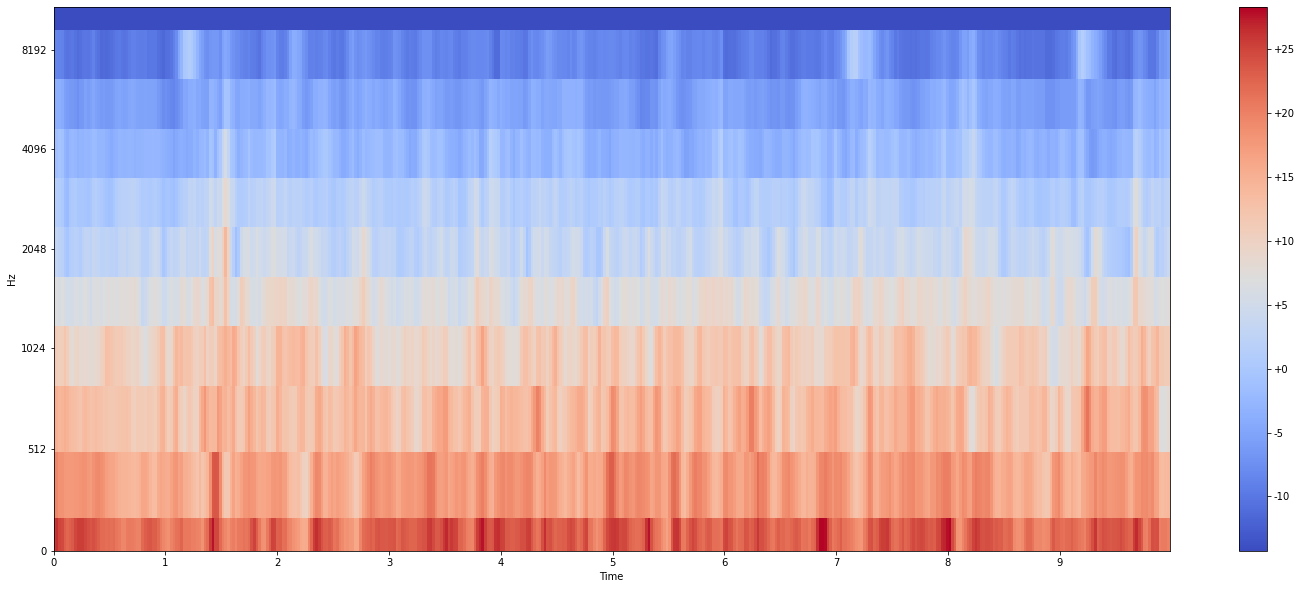

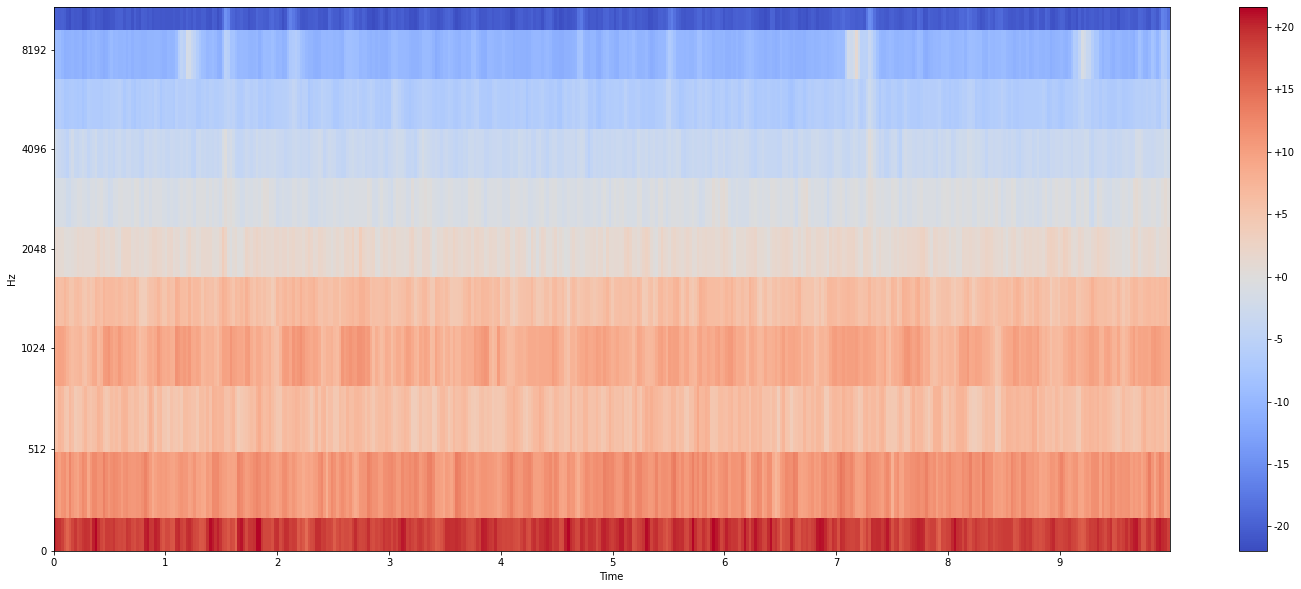

In [17]:

# def makeWindows2(data, numWindows):
arr2 = makeWindows3(test[0:2], 5)
whole = []

for data in tqdm(range(len(arr2[0:5]))):
    window = torch.from_numpy(np.array(arr2[data][0])).type(torch.float32)
    output = model(window.view(-1,1,11,86))
    whole.append([output, arr2[data][1], arr2[data][2]])

wholeNumpy = np.array([[whole[0][0].detach().numpy().reshape(11,86), whole[0][1], whole[0][2]], [whole[1][0].detach().numpy().reshape(11,86), whole[1][1], whole[1][2]], [whole[2][0].detach().numpy().reshape(11,86), whole[2][1], whole[2][2]], [whole[3][0].detach().numpy().reshape(11,86), whole[3][1], whole[3][2]], [whole[4][0].detach().numpy().reshape(11,86), whole[4][1], whole[4][2]]])
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
melspec = reconstruct(np.array(wholeNumpy), 5, 1)
melspec = np.array(melspec)

plt.figure(figsize=(25,10))
librosa.display.specshow(melspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

plt.figure(figsize=(25,10))
librosa.display.specshow(test[0][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()


In [18]:
wholeNumpy.shape

(5, 3)

In [19]:
thing = criterion(torch.from_numpy(melspec).type(torch.float32), torch.from_numpy(test[0][0]).type(torch.float32))
print(thing.item())

C:\Users\JasonZhou\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([11, 430])) that is different to the input size (torch.Size([1, 11, 430])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


17.670879364013672


In [20]:
sum(val_loss[0:5]) / 5

tensor(17.6709, grad_fn=<DivBackward0>)